# CNN Model for Handwritten Digit Recognition - MNIST Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import numpy as np

In [2]:
# CNN model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
len(mnist_data)

60000

In [5]:
# Train/Test split
train_size = int(0.8 * len(mnist_data))
test_size = len(mnist_data) - train_size
train_data, test_data = random_split(mnist_data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


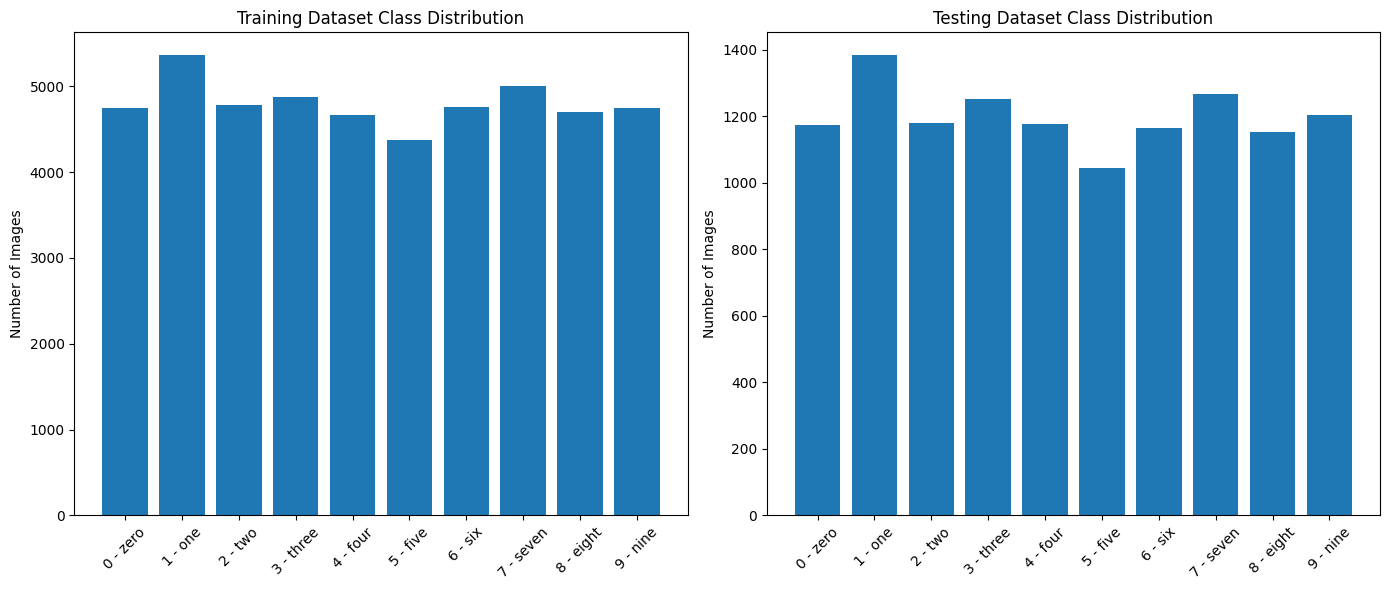

In [7]:
print(f"Number of classes: {len(mnist_data.classes)}")
print(f"Classes: {mnist_data.classes}")

# Count the number of images per class
train_indices = train_data.indices
test_indices = test_data.indices

train_counts = Counter([mnist_data.targets[i].item() for i in train_indices])
test_counts = Counter([mnist_data.targets[i].item() for i in test_indices])

# Get the number of classes and labels
classes = list(mnist_data.classes)

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Training dataset distribution
ax[0].bar(classes, [train_counts.get(i, 0) for i in range(len(classes))])
ax[0].set_title("Training Dataset Class Distribution")
ax[0].set_xticks(range(len(classes)))
ax[0].set_xticklabels(classes, rotation=45)
ax[0].set_ylabel("Number of Images")

# Testing dataset distribution
ax[1].bar(classes, [test_counts.get(i, 0) for i in range(len(classes))])
ax[1].set_title("Testing Dataset Class Distribution")
ax[1].set_xticks(range(len(classes)))
ax[1].set_xticklabels(classes, rotation=45)
ax[1].set_ylabel("Number of Images")

plt.tight_layout()
plt.show()

In [8]:
# Function to visualize random images
def visualize_random_images(dataset, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2.5))
    for i in range(num_images):
        random_idx = torch.randint(0, len(dataset), size=(1,)).item()
        img, label = dataset[random_idx]
        img = img.squeeze()  # Remove the channel dimension
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

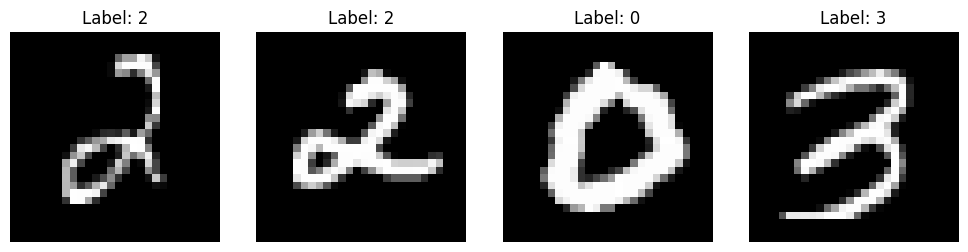

In [9]:
# Visualize random images
visualize_random_images(train_data)

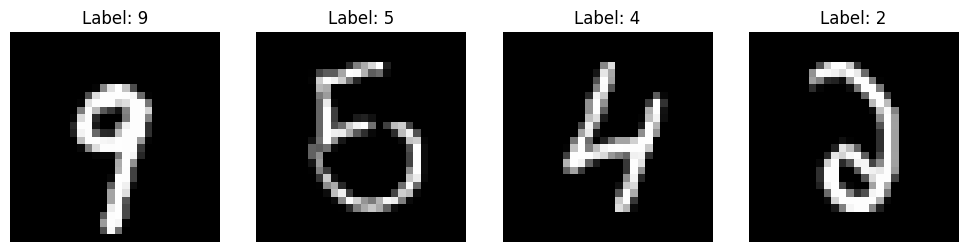

In [10]:
# Visualize random images
visualize_random_images(train_data)

In [11]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
NBR_EPOCHS= 5

for epoch in range(NBR_EPOCHS):  
    
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 0.0203
Epoch [2/5], Loss: 0.0587
Epoch [3/5], Loss: 0.0080
Epoch [4/5], Loss: 0.0007
Epoch [5/5], Loss: 0.0640



Accuracy: 0.9892
Classification Report:
              precision    recall  f1-score   support

    0 - zero       0.98      1.00      0.99      1175
     1 - one       0.99      0.99      0.99      1383
     2 - two       0.99      0.99      0.99      1181
   3 - three       0.99      0.99      0.99      1253
    4 - four       0.99      0.99      0.99      1177
    5 - five       0.99      0.99      0.99      1044
     6 - six       1.00      0.99      0.99      1166
   7 - seven       0.99      0.99      0.99      1266
   8 - eight       0.98      0.99      0.98      1152
    9 - nine       0.99      0.97      0.98      1203

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



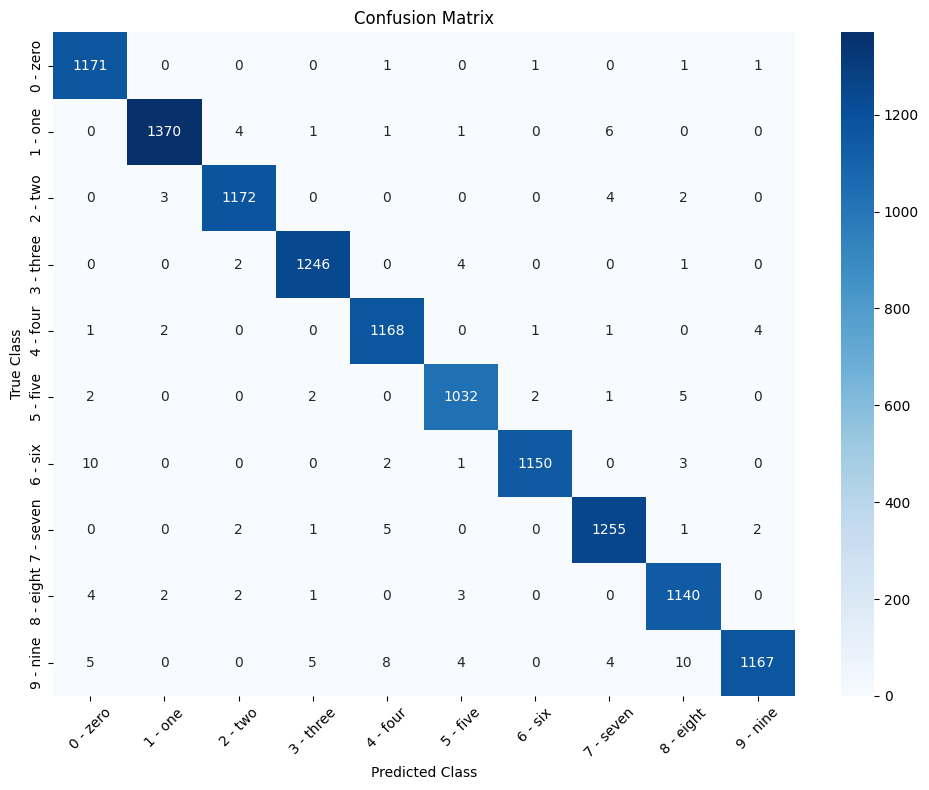

In [12]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

class_names = mnist_data.classes        

# Metrics using Sklearn
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ----------------------
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Save the trained model
torch.save(model.state_dict(), "mnist_cnn_model.pth")
print("Model saved")

Model saved
